In [1]:
import pandas as pd
import numpy as np

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.plot import plot_missing_value

import torch
from torch import nn, optim

In [2]:
df = pd.read_csv('D:/remote/datasets/dlfund/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


,missing_value,%
Pregnancies,0,0.00
Glucose,5,0.65
BloodPressure,35,4.56
SkinThickness,227,29.56
Insulin,374,48.70
BMI,11,1.43
DiabetesPedigreeFunction,0,0.00
Age,0,0.00
Outcome,0,0.00


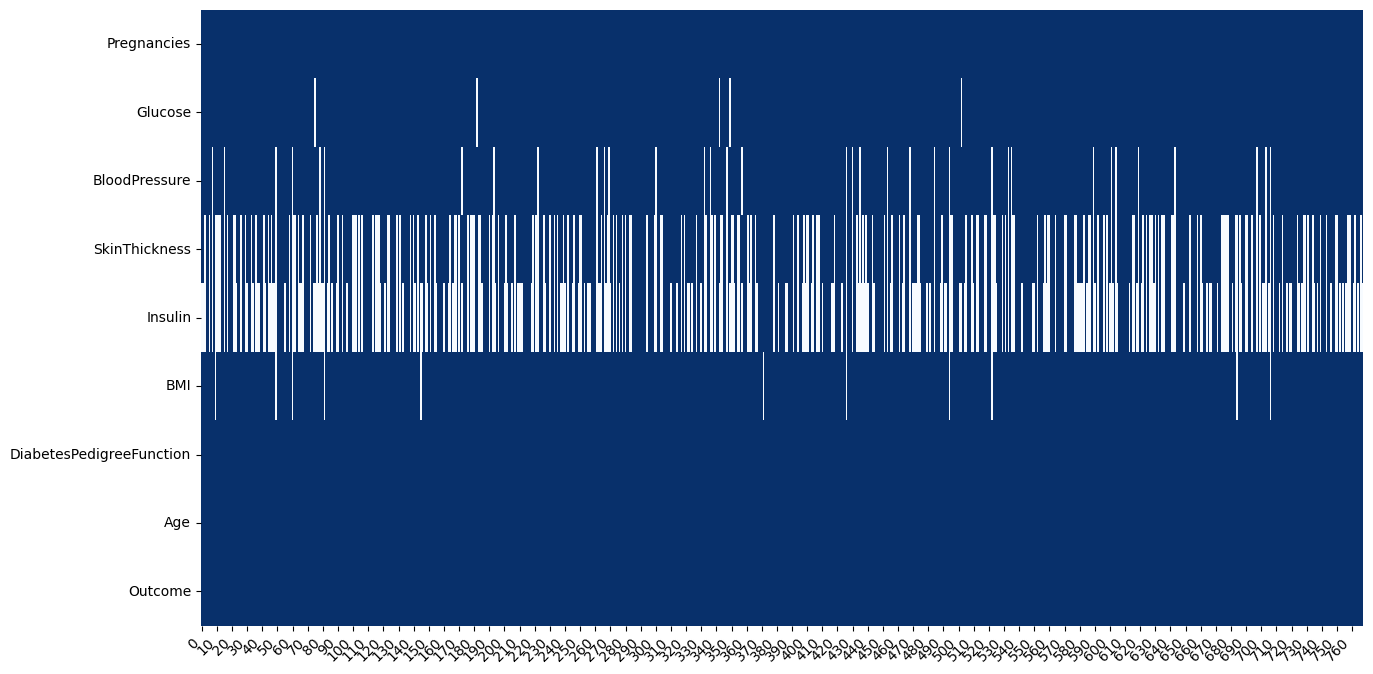

In [3]:
plot_missing_value(df, return_df=True)

In [4]:
df.drop(columns='Insulin', inplace=True)

In [5]:
# check imbalance
df.Outcome.value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

belum terlalu imbalance, akurasi 65% jika nebak semua tidak diabetes

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

X = df.drop(columns="Outcome")
y = df.Outcome.values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 7), (154, 7), (614,), (154,))

In [7]:
# preprocess
preprocessor = ColumnTransformer([
    ('num', num_pipe(), X_train.columns)
])

In [8]:
X_train = preprocessor.fit_transform(X_train)
# jangan di fit, karena nanti akan ada data leakage.
X_test = preprocessor.transform(X_test)

In [9]:
X_train

array([[1.00e+00, 9.00e+01, 6.20e+01, ..., 2.72e+01, 5.80e-01, 2.40e+01],
       [5.00e+00, 1.26e+02, 7.80e+01, ..., 2.96e+01, 4.39e-01, 4.00e+01],
       [2.00e+00, 1.05e+02, 5.80e+01, ..., 3.49e+01, 2.25e-01, 2.50e+01],
       ...,
       [1.00e+00, 9.70e+01, 7.00e+01, ..., 3.81e+01, 2.18e-01, 3.00e+01],
       [1.00e+01, 1.11e+02, 7.00e+01, ..., 2.75e+01, 1.41e-01, 4.00e+01],
       [4.00e+00, 1.44e+02, 5.80e+01, ..., 2.95e+01, 2.87e-01, 3.70e+01]])

<h2> Dataset & Dataloader

In [10]:
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train) # target karena klasifikasi 0 dan 1 (multiclass) maka menggunakan LongTensor. boleh memakai FloatTensor kalau pakai sigmoid/binary classification 0 sampai 1
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test) 

In [11]:
from torch.utils.data import DataLoader, TensorDataset

In [12]:
train_set = TensorDataset(X_train, y_train)
trainloader = DataLoader(train_set, batch_size=64, shuffle=True)

test_set = TensorDataset(X_test, y_test)
testloader = DataLoader(test_set, batch_size=64, shuffle=False)

<h2> Trainig Preparation - MCO

In [13]:
X_train.shape

torch.Size([614, 7])

model arsitektur

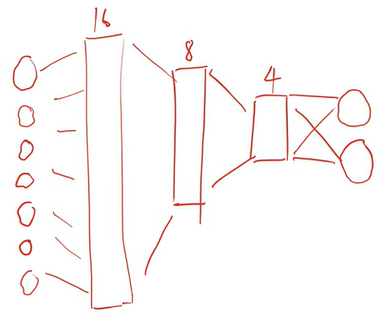

In [14]:
model = nn.Sequential(
    nn.Linear(7, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 2),
    nn.LogSoftmax(dim=1) #jika pakai crossentropyloss maka tidak perlu logsoftmax
)

criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

DRY = Don't Repeat Yourself

In [15]:
# ini masih repeat

epochs = 100
train_cost, test_cost = [], []
for i in range(epochs):
    model.train()
    cost = 0
    for feature, target in trainloader: 
        output = model(feature) 
        loss = criterion(output, target) 
        loss.backward() 

        optimizer.step() 
        optimizer.zero_grad() 

        cost += loss.item() * feature.shape[0]
    train_cost.append(cost / len(train_set))

    with torch.no_grad():
        model.eval()
        cost = 0
        for feature, target in testloader:
            output = model(feature) # feedforward
            loss = criterion(output, target) # hitung loss
            cost += loss.item() * feature.shape[0] # hitung total loss
        test_cost.append(cost / len(test_set))

    print(f'Epoch {i+1}/{epochs} | Loss: {loss.item():.4f} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f}', end='\r')


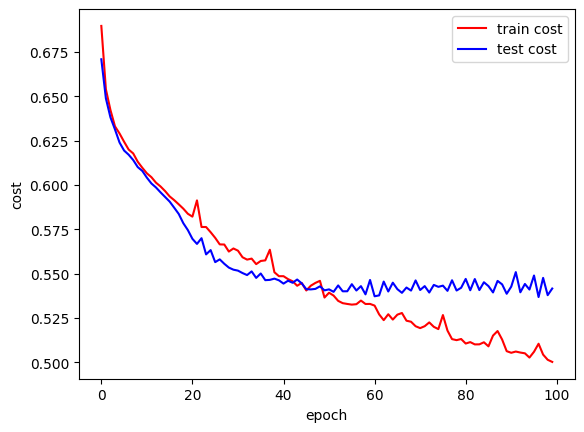

In [16]:
import matplotlib.pyplot as plt

plt.plot(train_cost, 'r-', label='train cost')
plt.plot(test_cost, 'b-', label='test cost')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend()

<h2> Predict

In [17]:
with torch.no_grad():
        model.eval()
        output = model(X_test) # output ini adalah logsoftmax bukan prediksi, hanya probabilitas

In [18]:
10**output

tensor([[2.4306e-02, 5.9988e-01],
        [9.7844e-01, 2.1629e-05],
        [6.4225e-01, 1.8058e-02],
        [2.2470e-01, 1.8197e-01],
        [7.5081e-01, 7.1567e-03],
        [4.1276e-01, 7.2056e-02],
        [6.3639e-01, 1.8846e-02],
        [2.7737e-03, 8.3040e-01],
        [6.5561e-01, 1.6346e-02],
        [6.1946e-02, 4.4161e-01],
        [2.3110e-01, 1.7639e-01],
        [4.0936e-01, 7.3330e-02],
        [2.6001e-01, 1.5332e-01],
        [2.8652e-01, 1.3486e-01],
        [2.3729e-01, 1.7115e-01],
        [2.7992e-01, 1.3924e-01],
        [1.2096e-01, 3.0895e-01],
        [5.0240e-01, 4.4336e-02],
        [6.3967e-03, 7.6176e-01],
        [4.9555e-01, 4.6099e-02],
        [6.3717e-01, 1.8741e-02],
        [7.6744e-03, 7.4377e-01],
        [3.4874e-01, 9.9536e-02],
        [1.7291e-02, 6.4812e-01],
        [1.4368e-01, 2.7343e-01],
        [9.8786e-01, 5.7346e-06],
        [1.1908e-01, 3.1216e-01],
        [6.0637e-01, 2.3264e-02],
        [1.2635e-01, 2.9998e-01],
        [6.658

In [19]:
torch.exp(output)

tensor([[0.1990, 0.8010],
        [0.9906, 0.0094],
        [0.8251, 0.1749],
        [0.5229, 0.4771],
        [0.8830, 0.1170],
        [0.6809, 0.3191],
        [0.8218, 0.1782],
        [0.0775, 0.9225],
        [0.8325, 0.1675],
        [0.2988, 0.7012],
        [0.5293, 0.4707],
        [0.6785, 0.3215],
        [0.5571, 0.4429],
        [0.5811, 0.4189],
        [0.5354, 0.4646],
        [0.5752, 0.4248],
        [0.3996, 0.6004],
        [0.7416, 0.2584],
        [0.1115, 0.8885],
        [0.7372, 0.2628],
        [0.8222, 0.1778],
        [0.1206, 0.8794],
        [0.6329, 0.3671],
        [0.1717, 0.8283],
        [0.4306, 0.5694],
        [0.9947, 0.0053],
        [0.3969, 0.6031],
        [0.8047, 0.1953],
        [0.4072, 0.5928],
        [0.8381, 0.1619],
        [0.8383, 0.1617],
        [0.8756, 0.1244],
        [0.5185, 0.4815],
        [0.4852, 0.5148],
        [0.5444, 0.4556],
        [0.8713, 0.1287],
        [0.7299, 0.2701],
        [0.8072, 0.1928],
        [0.6

In [20]:
X_test.shape

torch.Size([154, 7])

In [21]:
output.shape

torch.Size([154, 2])

In [22]:
# ambil siapa yang paling besar, ambil untuk prediksi
pred = output.argmax(dim=1)
pred

tensor([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0])

<h2> Accuracy

In [23]:
y_test.shape

torch.Size([154])

In [24]:
y_test

tensor([0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0])

In [25]:
y_test == pred

tensor([False,  True,  True, False,  True,  True, False,  True,  True, False,
         True, False,  True,  True, False, False, False,  True, False,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True, False,  True,  True, False, False,
         True,  True,  True, False,  True,  True, False,  True,  True, False,
        False, False,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True, False,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True, False, False,  True, False, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
        False,  True, False, False, False,  True,  True,  True,  True,  True,
        False, False,  True, False, False,  True, False,  True, 

In [26]:
acc = (y_test == pred).to(torch.float32).mean()
acc

tensor(0.7078)

<h2> Dropout layer + update layer

In [27]:
model = nn.Sequential(
    nn.Linear(7, 32),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(8, 2),
    nn.LogSoftmax(dim=1) #jika pakai crossentropyloss maka tidak perlu logsoftmax
)

criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

<h2> Training

In [28]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = correct = 0
    for feature, target in dataloader:
        output = model(feature) # forward
        loss = criterion(output, target) # hitung loss

        if mode == "train": # hanya ada di train, hitung backpropagation
            loss.backward() 
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item() # hitung akurasi
    cost = cost / len(dataset)
    acc = correct / len(dataset)
    return cost, acc


In [29]:
epochs = 1000
train_cost, test_cost = [], []
train_acc, test_acc = [], []

for i in range(epochs):
    cost, acc = loop_fn("train", train_set, trainloader, model, criterion, optimizer)
    train_cost.append(cost)
    train_acc.append(acc)
    with torch.no_grad():
        cost, acc = loop_fn("test", test_set, testloader, model, criterion, optimizer)
        test_cost.append(cost)
        test_acc.append(acc)

    print(f"\rEpoch: {i+1}/{epochs} | train_cost: {train_cost[-1]:.4f} | test_cost: {test_cost[-1]:.4f} | train_acc: {train_acc[-1]:.4f} | test_acc: {test_acc[-1]:.4f}", end=" ")    

Epoch: 4/1000 | train_cost: 1.2466 | test_cost: 0.6603 | train_acc: 0.5277 | test_acc: 0.6494 

Epoch: 1000/1000 | train_cost: 0.5507 | test_cost: 0.6203 | train_acc: 0.7215 | test_acc: 0.6494 

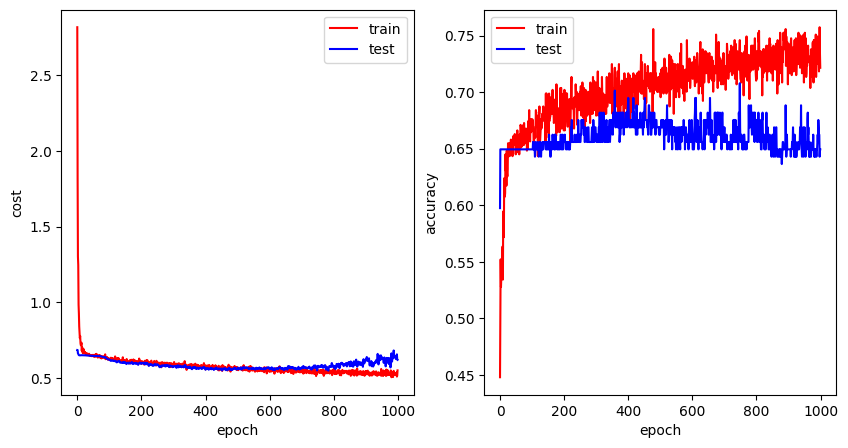

In [30]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(train_cost, 'r-', label='train')
plt.plot(test_cost, 'b-', label='test')
plt.xlabel('epoch')
plt.ylabel('cost')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc,  'r-', label='train')
plt.plot(test_acc,  'b-', label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()


Save ~~Model~~ Weights

In [36]:
import os

os.makedirs("model", exist_ok=True)

In [37]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 2.4989e-01, -2.2214e-01, -1.1379e-01,  2.0791e-01,  3.8535e-02,
                       -1.9702e-02, -1.0982e-02],
                      [ 9.1539e-02,  1.5468e-01,  8.0986e-02, -1.6175e-01, -3.3871e-01,
                        2.0012e-01, -1.6614e-01],
                      [ 2.1567e-01, -1.9622e-01,  5.8801e-03, -1.3751e-01,  1.0679e-01,
                       -1.3167e-01, -3.1340e-01],
                      [ 1.7943e-01,  2.8876e-02, -4.7978e-02, -2.5937e-02,  1.0297e-01,
                        6.2911e-01, -4.7437e-03],
                      [ 8.4286e-01,  2.4628e-01, -4.0503e-01, -2.1149e-01, -4.5080e-01,
                       -9.2431e-02, -3.9935e-02],
                      [-5.1830e-01, -1.2176e-01,  3.0263e-01, -1.6964e-01,  9.0576e-02,
                       -7.4616e-01, -1.9100e-01],
                      [ 2.6996e-01, -2.0387e-01, -1.6700e-01,  2.3993e-01, -2.7467e-01,
                       -3.3217e-01,  1.6991e-01],
        

In [38]:
torch.save(model.state_dict(), 'model/weights.pth')

<h2> Logging

In [39]:
log = {
    "train_cost": train_cost,
    "train_cost": test_cost,
    "train_acc": train_acc,
    "test_acc": test_acc
}

torch.save(log, 'model/log.pth')

<h2> Load Model

In [40]:
model = nn.Sequential(
    nn.Linear(7, 32),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(8, 2),
    nn.LogSoftmax(dim=1) #jika pakai crossentropyloss maka tidak perlu logsoftmax
)

akan masih random

In [41]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1405, -0.0602,  0.3295, -0.3018, -0.0902, -0.1587,  0.1906],
                      [-0.2142,  0.2312, -0.2390, -0.3180, -0.3748,  0.1656, -0.1867],
                      [ 0.0619,  0.0670,  0.1953,  0.2887, -0.1019,  0.1557,  0.2438],
                      [-0.2289, -0.2424, -0.1084,  0.0249,  0.1963,  0.3111,  0.3756],
                      [-0.1508, -0.2149,  0.3625,  0.1857,  0.2068,  0.1435, -0.1179],
                      [ 0.1735, -0.3578, -0.0822, -0.3024,  0.0479, -0.1953,  0.1926],
                      [-0.0322, -0.2500, -0.3307, -0.3522, -0.2178, -0.0458,  0.1867],
                      [-0.1578, -0.2339, -0.1435, -0.2197,  0.3172,  0.1108,  0.2294],
                      [ 0.1919,  0.1364, -0.1711,  0.3623, -0.1374, -0.0636, -0.1186],
                      [ 0.0015,  0.2289,  0.0161, -0.1831, -0.2515,  0.0083, -0.2156],
                      [-0.2766, -0.3129, -0.2006,  0.2802,  0.1538,  0.2130,  0.2499],
                 

In [42]:
weights = torch.load("model/weights.pth", map_location='cpu')

check prediksi menggunakan weight acak pada awal model

In [43]:
with torch.no_grad():
        model.eval()
        output = model(X_test)
        pred = output.argmax(dim=1)
        acc = (pred == y_test).to(torch.float32).mean()
acc        

tensor(0.3506)

check prediksi menggunakan weight yg sudah di train

In [44]:
model.load_state_dict(weights)

<All keys matched successfully>

In [45]:
with torch.no_grad():
        model.eval()
        output = model(X_test)
        pred = output.argmax(dim=1)
        acc = (pred == y_test).to(torch.float32).mean()
acc    

tensor(0.6494)